## ARISE-GERI data analysis



*import libraries*

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime 
import os
import glob
from scipy import interpolate
import statistics

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.options.display.max_rows = 50

### Data

In [4]:
patient_nr = 'P07'
path = './data/ARISE_GERI/' + patient_nr 

**H-MAN sensor data (FILE_ID.dat)**

In [5]:
# loop dfs from *.dat for defined patient_nr
list_of_dfs = []

list_of_dfs = [pd.read_csv(filename, sep='\t+', header=[1]) for filename in glob.glob(path + '/*.dat')]

In [6]:
# sample of one df
list_of_dfs[0]

,Time_msec,RawDataX,RawDataY,RawDataTorqueLeft,RawDataTorqueRight
0,1,0.133907,-0.000302,0,0
1,2,0.133907,-0.000302,0,0
2,3,0.133907,-0.000302,0,0
3,4,0.133907,-0.000302,0,0
4,5,0.133907,-0.000302,0,0
...,...,...,...,...,...
888595,1887501,0.082461,0.212950,0,0
888596,1887502,0.082461,0.213000,0,0
888597,1887503,0.082461,0.213000,0,0
888598,1887504,0.082461,0.213050,0,0


In [7]:
# change column names to lowercase
for df in list_of_dfs:
    df.columns = df.columns.str.lower()

**Time-stamped data (FILE_ID.tsd)**

In [8]:
# loop tsds from *.tsd for each patient
list_of_tsds = []

list_of_tsds = [pd.read_csv(filename, sep='\t+', header=[1]) for filename in glob.glob(path + '/*.tsd')]

In [9]:
list_of_tsds[0]

,t,event_type,Obstacles/Outcome
0,20,service_event_start,0
1,1330,collision,1
2,5145,collision,1
3,14995,collision,1
4,15320,collision,1
...,...,...,...
519,1880836,retrieval,0
520,1881855,collision,1
521,1887515,outcome_type,1
522,1887515,service_event_end,1


In [10]:
# standardize columns names
for tsd in list_of_tsds:
    tsd.columns = tsd.columns.str.replace(' ','')
    tsd.columns = tsd.columns.str.replace('/','_')
    tsd.columns = tsd.columns.str.lower() 

**Game parameters (FILE_ID.par)**

In [11]:
list_of_pars = []

list_of_pars = [pd.read_csv(filename, header=[1]) for filename in glob.glob(path + '/*.par')]

In [12]:
# converting to one column 
list_of_pars[0]

,CustomerCount: 12
0,SessionTimeout: 60
1,FadeOutTime: 15
2,CustomerArrivalTime: 4
3,TotalBlocks: 7
4,CognitiveLevel: 2
5,HapticsLevel: 2
6,Damping Matrix A: 100 200 0 0
7,Damping Matrix B: 0 0 0 0
8,Damping Matrix C: -30 -30 30 0


**Researcher reports (FILE_ID.rep)**

In [13]:
list_of_reps = []

for filename in glob.glob(path + '/*.rep'):
    rep = pd.read_csv(filename, header=[0])
    rep.set_axis(['patientid'], axis=1, inplace=True)
    rep = rep['patientid'].str.split(' ', n=1, expand=True)
    rep = rep.rename(columns={0 : 'parameter', 1 : 'value'})
    rep['value'] = rep['value'].str.replace(' ','')
    list_of_reps.append(rep)


In [14]:
list_of_reps[0]

,parameter,value
0,Patient,ID:p07_trial
1,SessionTerminationCondition,Completed
2,SessionDuration,31.15
3,sumofOutcomesType1,70
4,sumofOutcomesType2,14
5,sumofOutcomesType3,3
6,TotalCustomersServed,84
7,AverageReactionTime,14.37722
8,AverageSpeed,1
9,CollisionRate,2


**quality timestamp check**

In [15]:
for index in range(0,len(list_of_tsds)):
    diff = abs(list_of_tsds[index]['t'].iloc[-1]  - list_of_dfs[index]['time_msec'].iloc[-1]) 
    if diff > 15:
        print(f'trial{index},{diff} msec, TIME DISCREPANCY IN DATA')
    else:
        print(f'trial{index} pass')

trial0 pass
trial1 pass
trial2 pass
trial3 pass
trial4 pass
trial5 pass
trial6 pass
trial7 pass


### EDA

#### wrt svc_event

##### interpolate sensor data

In [16]:
def convert_time(row):
    '''convert msec to min'''
    minutes, seconds = divmod(row['t'] / 1000, 60)
    row['t_min'] = f'{minutes:0>2.0f}'  # only in min
    return row

**merge main**

In [17]:
list_of_mains = []

for tsd, df in zip(list_of_tsds,list_of_dfs):
    # check duplicates
    ids = df['time_msec']
    df[ids.isin(ids[ids.duplicated()])]
    
    # drop duplicates
    df = df.drop_duplicates(subset=['time_msec'],keep='first')
    
    df = df.set_index('time_msec')
    df = df.reindex(range(0,df.index.astype(int)[-1]+1), fill_value=np.nan)
    df = df.reset_index()
    df.drop(labels=0,axis=0,inplace=True)
    
    # interpolate missing data
    df['rawdatax'] = df['rawdatax'].interpolate().values.ravel().tolist()
    df['rawdatay'] = df['rawdatay'].interpolate().values.ravel().tolist()
    
    # merge main df
    main = pd.merge(tsd, df, how='left', left_on='t', right_on='time_msec')
    main = main.apply(convert_time, axis=1)
    main['t_min'] = main['t_min'].astype(int)
    list_of_mains.append(main)

In [18]:
list_of_mains[0]

,t,event_type,obstacles_outcome,time_msec,rawdatax,rawdatay,rawdatatorqueleft,rawdatatorqueright,t_min
0,20,service_event_start,0,20.0,0.133907,-0.000302,0.0,0.0,0
1,1330,collision,1,1330.0,0.133907,-0.000302,NaN,NaN,0
2,5145,collision,1,5145.0,0.109353,0.075373,0.0,0.0,0
3,14995,collision,1,14995.0,0.319889,0.157482,0.0,0.0,0
4,15320,collision,1,15320.0,0.319663,0.138054,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...
519,1880836,retrieval,0,1880836.0,0.289429,0.176934,0.0,0.0,31
520,1881855,collision,1,1881855.0,0.281596,0.183967,NaN,NaN,31
521,1887515,outcome_type,1,NaN,NaN,NaN,NaN,NaN,31
522,1887515,service_event_end,1,NaN,NaN,NaN,NaN,NaN,31


In [19]:
## double check NaN beginning and end of df



##### mean speed 

In [20]:
# mean speed
list_svc = []
mean_speed = []
list_of_tot_svc = []

for idx, main in enumerate(list_of_mains):
    svc_event = main[main['event_type'].str.contains('service_event')]

    # index pairs of service_event start/end
    nr = 0
    svc_event['sequence'] = 0
    for index, event in enumerate(svc_event['event_type']):
        if event == 'service_event_start':
            svc_event['sequence'].iloc[index] = nr
        else:
            svc_event['sequence'].iloc[index] = nr
            nr += 1  
    
    # group events based on svc_events
    svc_event[['time_diff','x_diff','y_diff']]=svc_event.groupby('sequence')[['time_msec','rawdatax','rawdatay']].diff()
    svc_event['step_size'] = np.sqrt(svc_event['x_diff']**2+svc_event['y_diff']**2)
    svc_event['speed'] = (svc_event['step_size'])/(svc_event['time_diff']/1000)
    svc_event.drop(columns=['rawdatatorqueleft','rawdatatorqueright'],inplace=True)
    svc_event = svc_event.dropna()
    list_svc.append(svc_event)
    
    # total number of customers served
    list_of_tot_svc.append(int(list_of_reps[idx]['value'][6]))

    mean_speed.append(statistics.mean(svc_event['speed']))

In [21]:
# sample of one df
list_svc[0]

,t,event_type,obstacles_outcome,time_msec,rawdatax,rawdatay,t_min,sequence,time_diff,x_diff,y_diff,step_size,speed
8,25750,service_event_end,1,25750.0,0.287946,0.218630,0,0,25730.0,0.154039,0.218931,0.267692,0.010404
17,46240,service_event_end,1,46240.0,0.149254,0.214693,0,1,20490.0,-0.138692,-0.003936,0.138748,0.006771
24,76740,service_event_end,1,76740.0,0.222802,0.213416,1,2,30500.0,0.073548,-0.001277,0.073559,0.002412
31,103680,service_event_end,1,103680.0,0.287393,0.215111,1,3,26940.0,0.064591,0.001695,0.064613,0.002398
35,120745,service_event_end,1,120745.0,0.145896,0.214508,2,4,17065.0,-0.141497,-0.000603,0.141499,0.008292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,1836880,service_event_end,1,1836880.0,0.265201,0.214533,30,81,8065.0,0.054076,-0.000060,0.054076,0.006705
501,1847080,service_event_end,1,1847080.0,0.072481,0.213419,30,82,10200.0,-0.192719,-0.001114,0.192723,0.018894
507,1858425,service_event_end,1,1858425.0,0.137526,0.214286,30,83,11345.0,0.065045,0.000867,0.065051,0.005734
512,1866650,service_event_end,1,1866650.0,0.212740,0.213989,31,84,8225.0,0.075214,-0.000298,0.075214,0.009145


In [22]:
## quality check 
# no end for the last service_event_
list_of_tsds[0][list_of_tsds[0]['event_type'].str.contains('service')].tail(5)

,t,event_type,obstacles_outcome
513,1866650,service_event_start,0
517,1876135,service_event_end,1
518,1876135,service_event_start,0
522,1887515,service_event_end,1
523,1887515,service_event_start,0


In [23]:
# result mean_speed of all trials
mean_speed

[0.005693599430578935,
 0.010346748816988546,
 0.008458605998819535,
 0.008165274297757768,
 0.007344572617415857,
 0.010713381377457358,
 0.010841142836542512,
 0.009560382352561769]

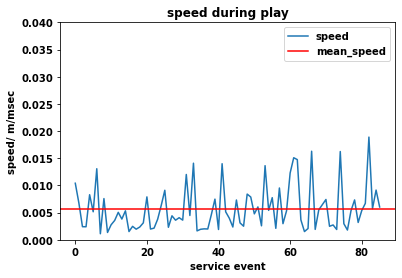

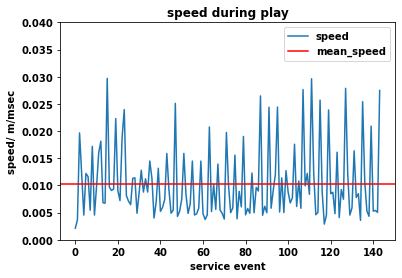

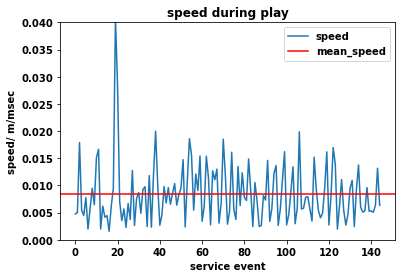

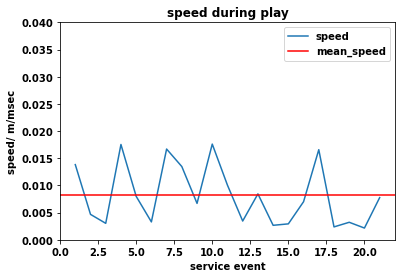

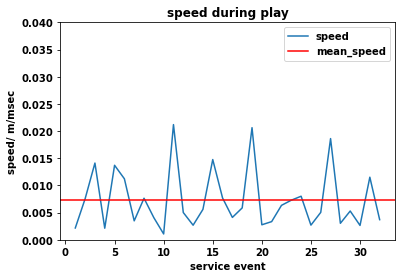

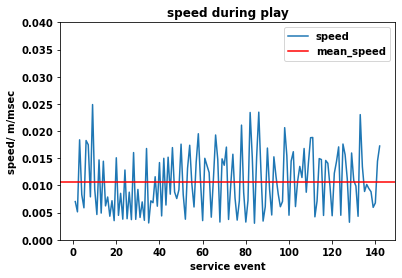

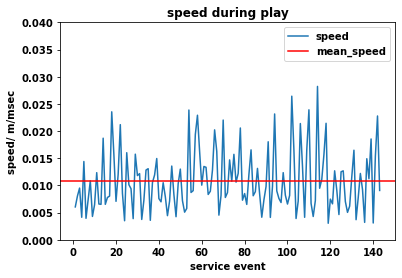

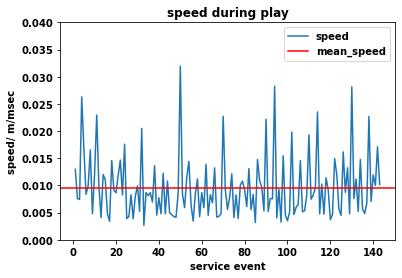

In [24]:
# plot speed and mean_speed based on svc_event
for index, svc_event in enumerate(list_svc):
    fig, ax = plt.subplots()

    ax.plot('sequence','speed',data=svc_event);
    ax.axhline(y=mean_speed[index], color='r', linestyle='-')
    
    plt.legend(['speed','mean_speed'])
    plt.xlabel('service event')
    plt.ylabel('speed/ m/msec')
    plt.ylim([0,0.040])
    plt.title('speed during play'); 

**how does the system determine a correction/rectification made?**


##### service event errors rate

 1 (Correct item & correct person in sequence) 
 <br> 2 (Correct item & wrong person in sequence)
 <br> 3 (Wrong item & wrong person in sequence).

In [25]:
# error rate
error_rate = []

for index, (main, svc_event) in enumerate(zip(list_of_mains,list_svc)):
    svc_error = main[main['event_type']=='service_event_end']['obstacles_outcome'].unique()
    
#     svc_event.reset_index(inplace=True)
    total_svc = int(svc_event['sequence'].tail(1))
    if 2 in svc_error:
        svc_error_2 = svc_event[svc_event['obstacles_outcome']==2]['obstacles_outcome'].count()
    else:
        svc_error_2 = 0
    if 3 in svc_error:
        svc_error_3 = svc_event[svc_event['obstacles_outcome']==3]['obstacles_outcome'].count()
    else:
        svc_error_3 = 0
        
    error_rate.append((svc_error_2 + svc_error_3)/list_of_tot_svc[index])


In [26]:
# result error_rate based on svc_event
error_rate

[0.20238095238095238,
 0.0,
 0.013888888888888888,
 0.0,
 0.0,
 0.006944444444444444,
 0.0,
 0.0]

##### collision rate

collisions=1 if shelf
<br> collisions=2 if object

In [27]:
# collision rate
collision_rate = []

for index, main in enumerate(list_of_mains):
    coll_1 = main[(main['event_type']=='collision') & (main['obstacles_outcome']==1)]['obstacles_outcome'].count()
    coll_2 = main[(main['event_type']=='collision') & (main['obstacles_outcome']==2)]['obstacles_outcome'].count()
    collision_rate.append((coll_1 + coll_2)/list_of_tot_svc[index])
    

In [28]:
collision_rate

[2.0357142857142856,
 1.5902777777777777,
 1.5902777777777777,
 1.5454545454545454,
 2.0303030303030303,
 1.4027777777777777,
 1.3194444444444444,
 1.5172413793103448]

#### rolling

##### mean speed (rolling)

In [29]:
# define window of interest
# this applies to all parameters
window = int(input("window: "))

window: 7


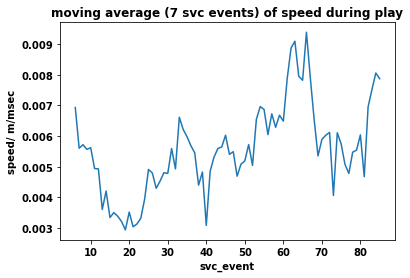

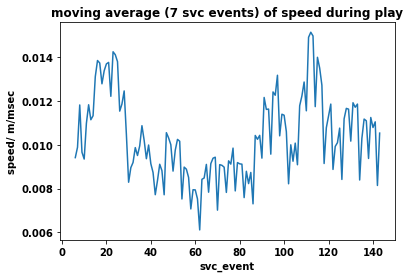

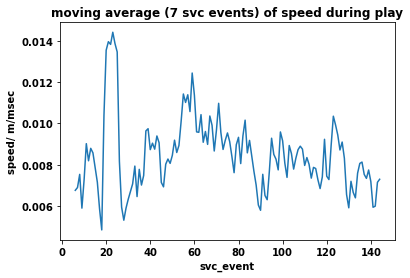

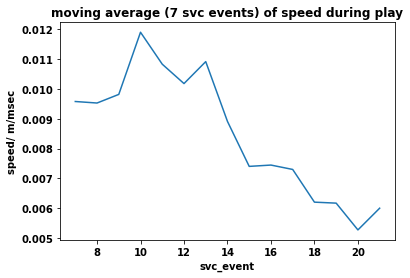

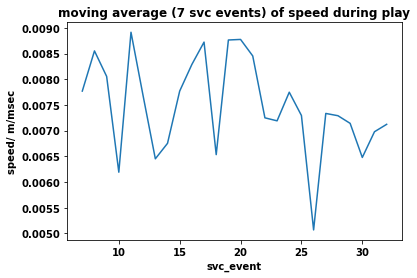

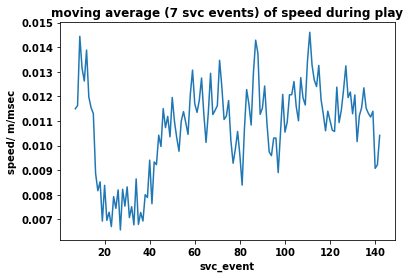

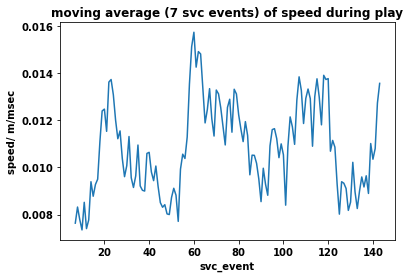

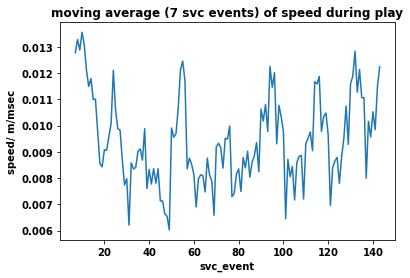

In [30]:
list_speed_roll = []

for index, svc_event in enumerate(list_svc):
    svc_event.set_index('sequence')
    svc_event['speed_roll']=svc_event['speed'].rolling(window).mean()
    list_speed_roll.append(svc_event['speed_roll'])
    
    #plot moving average based on window
    fig, ax = plt.subplots()
    ax.plot('sequence','speed_roll',data=svc_event);
    plt.xlabel('svc_event')
    plt.ylabel('speed/ m/msec')
    plt.title(f'moving average ({window} svc events) of speed during play'); 

##### svc event errors rate (rolling)

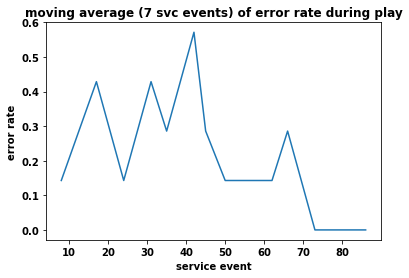

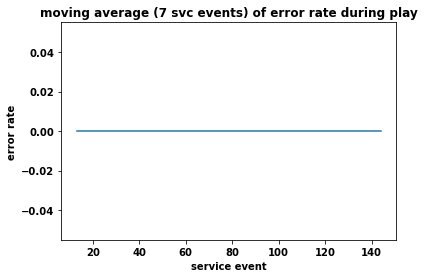

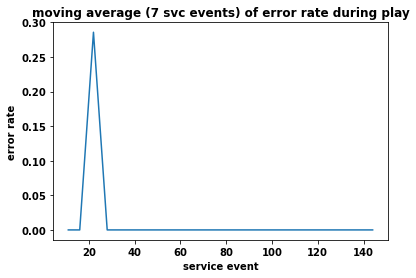

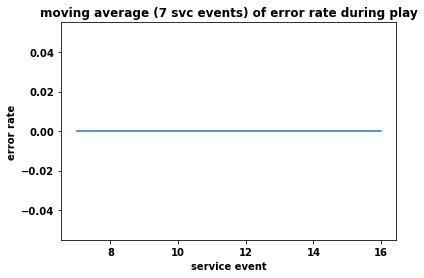

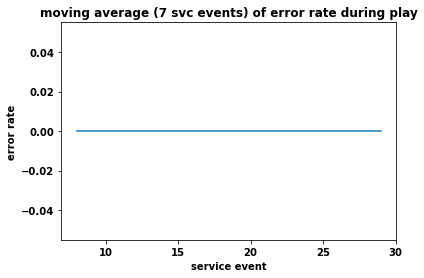

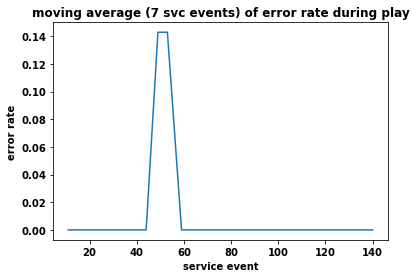

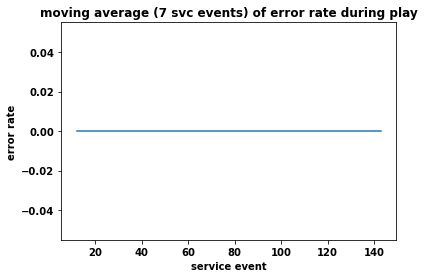

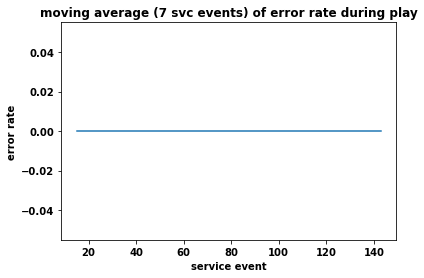

In [31]:
list_error_rate = []

for index, svc_event in enumerate(list_svc):
    svc_event['error_rate'] = np.nan
    
    for i in range(0,(len(svc_event)-window+1)):
        svc_error = svc_event[svc_event['event_type']=='service_event_end']['obstacles_outcome'][i:i+window].unique()
        if 2 in svc_error:
            svc_error_2 = svc_event[i:i+window][svc_event['obstacles_outcome']==2]['obstacles_outcome'].count()
        else:
            svc_error_2 = 0
        if 3 in svc_error:
            svc_error_3 = svc_event[i:i+window][svc_event['obstacles_outcome']==3]['obstacles_outcome'].count()
        else:
            svc_error_3 = 0
        svc_event['error_rate'][i+window] = (svc_error_2 + svc_error_3)/window
        list_error_rate.append((svc_error_2 + svc_error_3)/window)
    
    #plot moving average based on window
    fig, ax = plt.subplots()
    ax.plot('error_rate',data=svc_event);
    plt.xlabel('service event')
    plt.ylabel('error rate')
    plt.title(f'moving average ({window} svc events) of error rate during play'); 


##### total collision (svc, rolling)

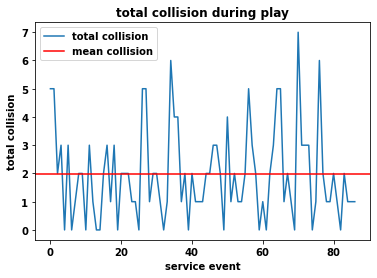

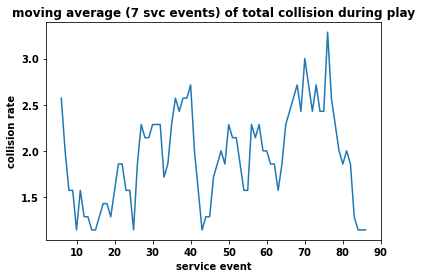

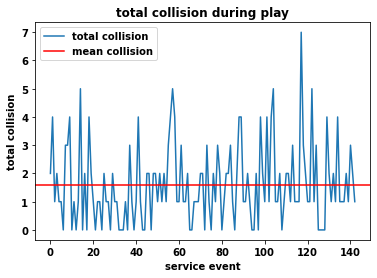

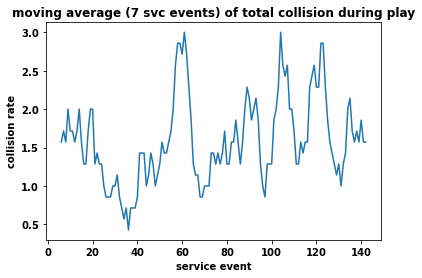

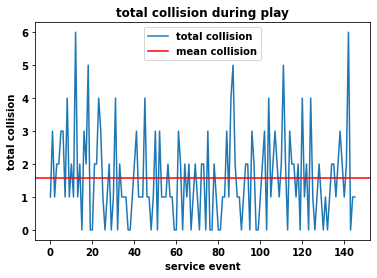

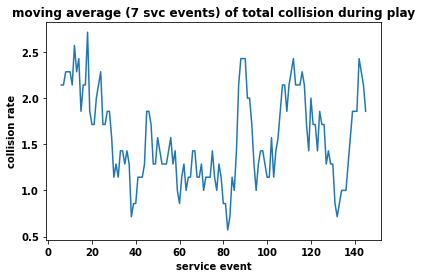

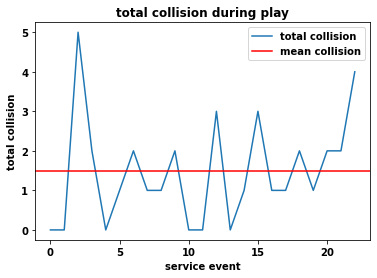

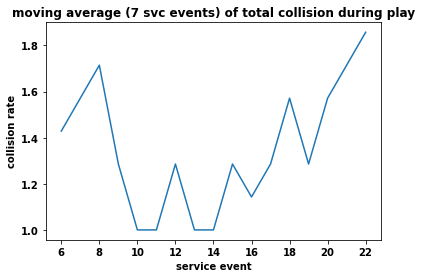

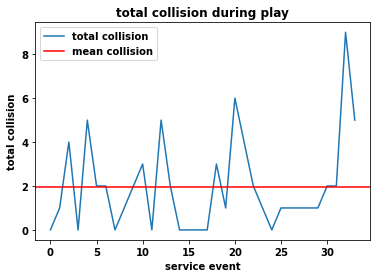

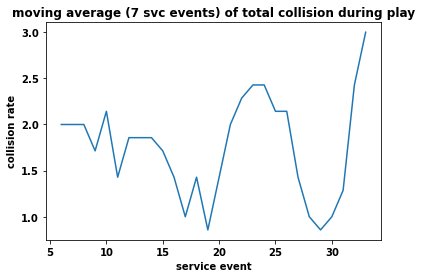

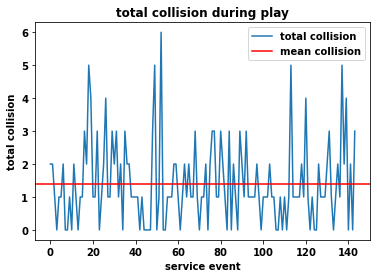

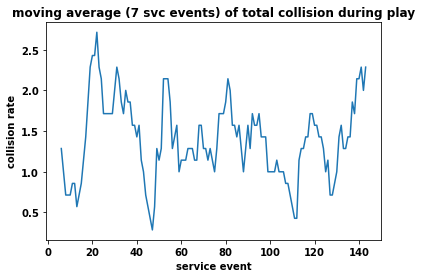

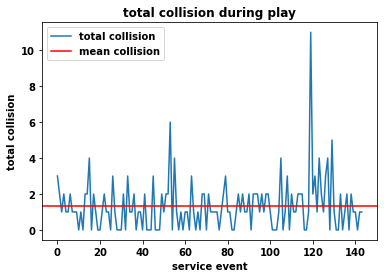

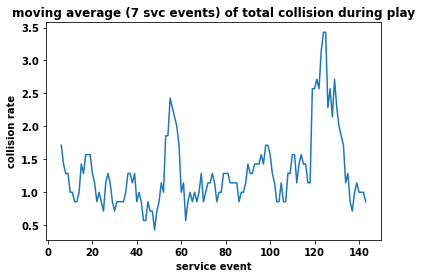

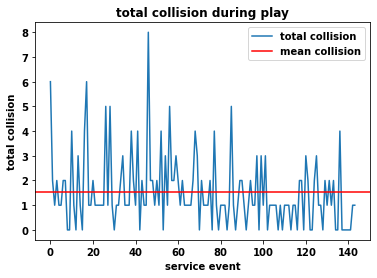

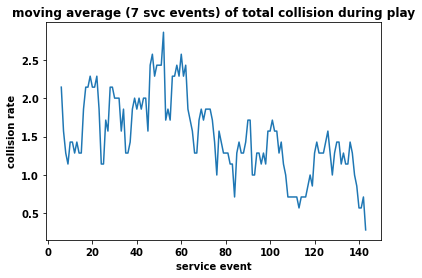

In [32]:
list_tot_coll = []

for main in list_of_mains:
    collision = main[main['event_type'].str.contains('collision|service')]
    
    # index pairs of service_event start/end
    nr = 0
    collision['sequence'] = 0
    for index, event in enumerate(collision['event_type']):
        if event == 'service_event_start':
            collision['sequence'].iloc[index] = nr
        elif event == 'collision':
            collision['sequence'].iloc[index] = nr
        elif event == 'service_event_end':
            collision['sequence'].iloc[index] = nr
            nr += 1 
            
    # collision 1
    coll_1 = collision[(collision['event_type']=='collision') & (collision['obstacles_outcome']==1)].groupby('sequence').count()[['obstacles_outcome']]
    coll_1 = coll_1.rename(columns={'obstacles_outcome':'coll_1'})

    # collision 2
    coll_2 = collision[(collision['event_type']=='collision') & (collision['obstacles_outcome']==2)].groupby('sequence').count()[['obstacles_outcome']]
    coll_2 = coll_2.rename(columns={'obstacles_outcome':'coll_2'})

    # total collisions
    total_coll = pd.merge(coll_1, coll_2, how='left', on='sequence').replace(np.nan,0)
    total_coll = total_coll.reindex(range(0,total_coll.index.astype(int)[-1]+1), fill_value=0)
    total_coll['total_coll'] = total_coll['coll_1'] + total_coll['coll_2']
    
    # mean total obstacles
    mean_total_obstacles = statistics.mean(total_coll['total_coll'])
    
    #
    fig, ax1 = plt.subplots()
    ax1.plot('total_coll',data=total_coll);
    ax1.axhline(y=mean_total_obstacles, color='r', linestyle='-')
    plt.legend(['total collision','mean collision'])
    plt.xlabel('service event')
    plt.ylabel('total collision')
    plt.title('total collision during play'); 
    
    # total collision (rolling)
    total_coll['total_coll7']=total_coll['total_coll'].rolling(window).mean()
    list_tot_coll.append(total_coll['total_coll7'])
    
    #plot moving average based on window
    fig, ax2 = plt.subplots()
    ax2.plot('total_coll7',data=total_coll);
    plt.xlabel('service event')
    plt.ylabel('collision rate')
    plt.title(f'moving average ({window} svc events) of total collision during play'); 

### plot summary of all trials

In [33]:
progress = pd.DataFrame({'mean_speed': mean_speed, 
                        'error_rate': error_rate, 
                        'collision_rate': collision_rate})


In [34]:
progress

,mean_speed,error_rate,collision_rate
0,0.005694,0.202381,2.035714
1,0.010347,0.000000,1.590278
2,0.008459,0.013889,1.590278
3,0.008165,0.000000,1.545455
4,0.007345,0.000000,2.030303
5,0.010713,0.006944,1.402778
6,0.010841,0.000000,1.319444
7,0.009560,0.000000,1.517241


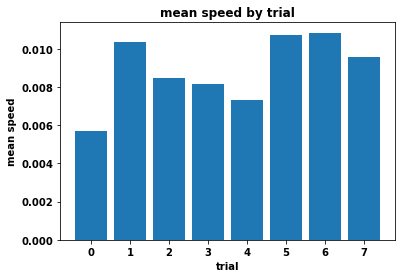

In [35]:
# plot mean_speed of all trials
plt.bar(progress.index,height=progress['mean_speed']);
plt.xlabel('trial')
plt.ylabel('mean speed');
plt.title('mean speed by trial');

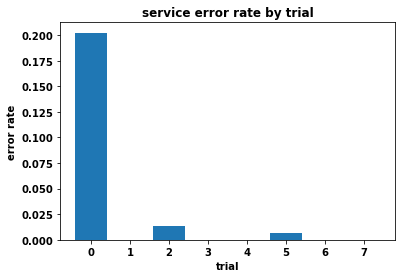

In [36]:
# plot error_rate of all trials
plt.bar(progress.index,height=progress['error_rate']);
plt.xlabel('trial')
plt.ylabel('error rate');
plt.title('service error rate by trial');

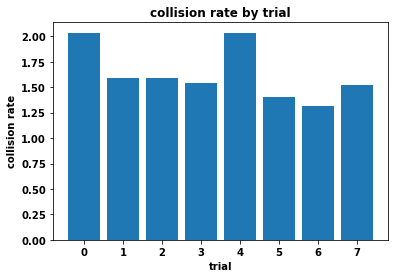

In [37]:
# plot collisions of all trials
plt.bar(progress.index,height=progress['collision_rate']);
plt.xlabel('trial')
plt.ylabel('collision rate');
plt.title('collision rate by trial');